## Navier-Stokes Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

### Data

In [3]:
# https://github.com/ComputationalDomain/PINNs/tree/main/Cylinder-Wake

import scipy
data = scipy.io.loadmat("data/cylinder_wake.mat")

U_star = data["U_star"]             # (5000, 2, 200)
P_star = data["p_star"]             # (5000, 200)
t_star = data["t"]                  # (200, 1)
X_star = data["X_star"]             # (5000, 2)

grid_size = 5000
t_size = 200
t = t_star.flatten()

U = U_star[:, 0, :]                         # (5000, 200)
V = U_star[:, 1, :]                         # (5000, 200)
P = P_star                                  # (5000, 200)
T = np.tile(t_star, [1, grid_size]).T       # (5000, 200)
X = np.tile(X_star[:, 0:1], [1, t_size])    # (5000, 200)
Y = np.tile(X_star[:, 1:2], [1, t_size])    # (5000, 200)

In [4]:
## Training Data
N_train = 5000
idx = np.random.choice(grid_size * t_size, N_train, replace=False)
x_data = torch.tensor(X.flatten()[:, None]).float().to(device)[idx]
y_data = torch.tensor(Y.flatten()[:, None]).float().to(device)[idx]
t_data = torch.tensor(T.flatten()[:, None]).float().to(device)[idx]
u_data = torch.tensor(U.flatten()[:, None]).float().to(device)[idx]
v_data = torch.tensor(V.flatten()[:, None]).float().to(device)[idx]
p_data = torch.tensor(P.flatten()[:, None]).float().to(device)[idx]

## Test Data
x_test = torch.tensor(X.flatten()[:, None]).float().to(device)
y_test = torch.tensor(Y.flatten()[:, None]).float().to(device)
t_test = torch.tensor(T.flatten()[:, None]).float().to(device)

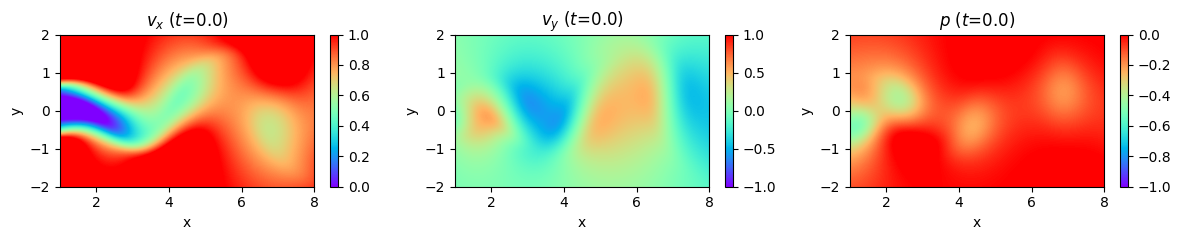

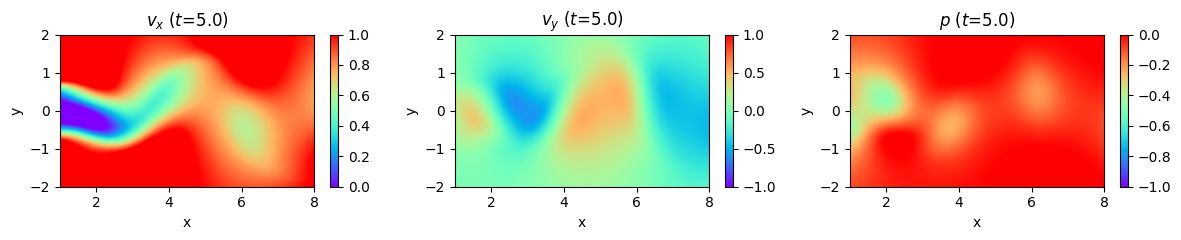

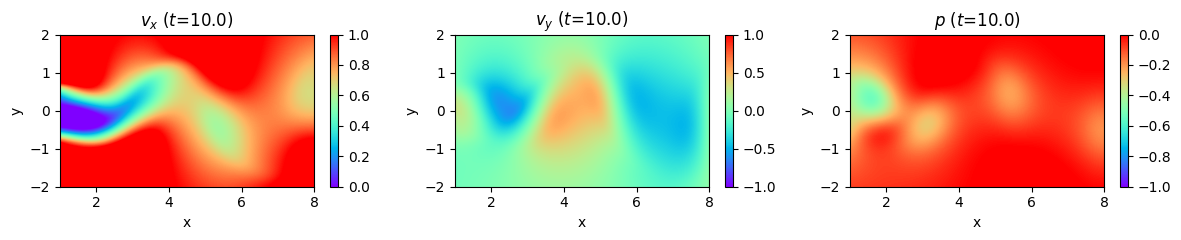

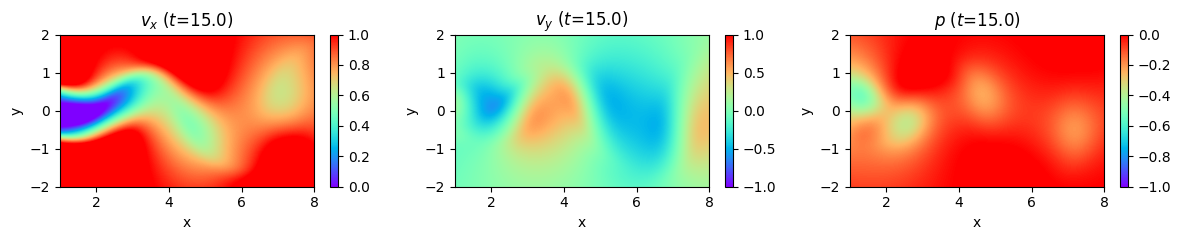

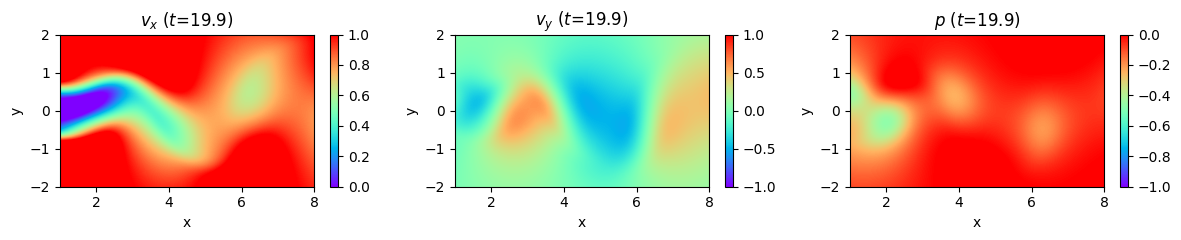

In [5]:
def show_result(idx, t, U, V, P):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 2.5))
    img1 = ax1.imshow(U[:, idx].reshape(50, 100), cmap='rainbow', aspect='auto', interpolation='bilinear',
                    vmin=np.round(U.min()), vmax=np.round(U.max()), origin='lower', extent=(1, 8, -2, 2))
    img2 = ax2.imshow(V[:, idx].reshape(50, 100), cmap='rainbow', aspect='auto', interpolation='bilinear',
                    vmin=np.round(V.min()), vmax=np.round(V.max()), origin='lower', extent=(1, 8, -2, 2))
    img3 = ax3.imshow(P[:, idx].reshape(50, 100), cmap='rainbow', aspect='auto', interpolation='bilinear',
                    vmin=np.round(P.min()), vmax=np.round(P.max()), origin='lower', extent=(1, 8, -2, 2))

    fig.colorbar(img1, ax=ax1)
    fig.colorbar(img2, ax=ax2)
    fig.colorbar(img3, ax=ax3)

    ax1.set_title(f"$v_x$ ($t$={t[idx]:.1f})")
    ax2.set_title(f"$v_y$ ($t$={t[idx]:.1f})")
    ax3.set_title(f"$p$ ($t$={t[idx]:.1f})")

    for ax in (ax1, ax2, ax3):
        ax.set(xlabel="x", ylabel="y")

    fig.tight_layout()
    plt.show()
    
show_result(0, t_star.flatten(), U, V, P)
show_result(50, t_star.flatten(), U, V, P)
show_result(100, t_star.flatten(), U, V, P)
show_result(150, t_star.flatten(), U, V, P)
show_result(-1, t.flatten(), U, V, P)

### Model

In [6]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 50),  nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 3)
        )
        
    def forward(self, x, y, t):
        xyt = torch.hstack([x, y, t])
        return self.model(xyt)  # (N, 1)

    def gradient(self, y, x):
        return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                                   create_graph=True, retain_graph=True)[0]

    def residual(self, x, y, t, nu=0.01):
        x.requires_grad = True
        y.requires_grad = True
        t.requires_grad = True

        res = self.forward(x, y, t)
        u, v, p = res[:, 0:1], res[:, 1:2], res[:, 2:3]

        u_x, u_y, u_t = self.gradient(u, x), self.gradient(u, y), self.gradient(u, t)
        v_x, v_y, v_t = self.gradient(v, x), self.gradient(v, y), self.gradient(v, t)
        u_xx, u_yy = self.gradient(u_x, x), self.gradient(u_y, y)
        v_xx, v_yy = self.gradient(v_x, x), self.gradient(v_y, y)
        p_x, p_y = self.gradient(p, x), self.gradient(p, y)

        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
        return torch.mean(f**2), torch.mean(g**2)
    
    def mse(self, x, y, t, u, v, p):
        x.requires_grad = True
        y.requires_grad = True
        t.requires_grad = True

        res = self.forward(x, y, t)
        u_pred, v_pred, p_pred = res[:, 0:1], res[:, 1:2], res[:, 2:3]
        return torch.mean((u_pred - u)**2), torch.mean((v_pred - v)**2), torch.mean((p_pred - p)**2)

### Training

In [7]:
## Training
set_seed(42)
model = PINN().to(device)
optimizer = optim.Adam(model.model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.95)

n_epochs = 10000
for epoch in range(1, n_epochs + 1):
    f_loss, g_loss = model.residual(x_data, y_data, t_data)                # pde loss (x_pde, y_pde, t_pde)
    u_loss, v_loss, p_loss = model.mse(x_data, y_data, t_data, u_data, v_data, p_data)
    loss = u_loss + v_loss + p_loss + f_loss + g_loss

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(f: {f_loss.item():.2e} g: {g_loss.item():.2e} "
              f"u: {u_loss.item():.2e} v: {v_loss.item():.2e} p: {p_loss.item():.2e})")

c:\WPy64-31180\python-3.11.8.amd64\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


KeyboardInterrupt: 

### Evaluation

In [ ]:
## Evaluation
model.eval()
with torch.no_grad():
    pred = model(x_test, y_test, t_test)
    
u_pred, v_pred, p_pred = pred.cpu().detach().numpy().T
U_pred = u_pred.reshape(5000, 200)
V_pred = v_pred.reshape(5000, 200)
P_pred = p_pred.reshape(5000, 200)

idx = 10
show_result(idx, t, U, V, P)
show_result(idx, t, U_pred, V_pred, P_pred)